In [17]:
# packages used
using HTTP
using CSV
using DataFrames
using Dates
using Plots

In [27]:
#	
labels = Dict("vlissingen"=>"Vlissingen","hoekvanholland"=>"Hoek van Holland","ijmuiden"=>"IJmuiden","harlingen"=>"Harlingen","denhelder"=>"Den Helder","delfzijl"=>"Delfzijl") 
psmsl_station_code= Dict( "vlissingen"=>20, 
"hoekvanholland"=>22,
"denhelder"=>23,
"delfzijl"=>24,
"harlingen"=>25,
"ijmuiden"=>32,)
@show psmsl_station_code["hoekvanholland"]

function psmsl_monthly_data(station_code)
    # https://psmsl.org/data/obtaining/rlr.monthly.data/20.rlrdata
    url = "https://www.psmsl.org/data/obtaining/rlr.monthly.data/$(station_code).rlrdata"
    println(url)
    df = CSV.File(HTTP.get(url).body, delim=';', header=false) |> DataFrame
    # Assign meaningful column names
    rename!(df, [:Year, :SeaLevel, :Col3, :Col4])
    return df
end

function psmsl_yearly_data(station_code)
    # https://psmsl.org/data/obtaining/rlr.annual.data/20.rlrdata
    url = "https://www.psmsl.org/data/obtaining/rlr.annual.data/$(station_code).rlrdata"
    println(url)
    df = CSV.File(HTTP.get(url).body, delim=';', header=false) |> DataFrame
    # Assign meaningful column names
    rename!(df, [:Year, :SeaLevel, :Col3, :Col4])
    return df
end


#hoekvanholland_monthly = psmsl_monthly_data(psmsl_station_code["hoekvanholland"])
#hoekvanholland_yearly = psmsl_yearly_data(psmsl_station_code["hoekvanholland"])
psmsl_yearly=Dict{String,DataFrame}()
for (key, value) in psmsl_station_code
    psmsl_yearly[key] = psmsl_yearly_data(value)
end
@show psmsl_yearly["denhelder"]
nothing

psmsl_station_code["hoekvanholland"] = 22
https://www.psmsl.org/data/obtaining/rlr.annual.data/23.rlrdata
https://www.psmsl.org/data/obtaining/rlr.annual.data/20.rlrdata
https://www.psmsl.org/data/obtaining/rlr.annual.data/22.rlrdata
https://www.psmsl.org/data/obtaining/rlr.annual.data/24.rlrdata
https://www.psmsl.org/data/obtaining/rlr.annual.data/25.rlrdata
https://www.psmsl.org/data/obtaining/rlr.annual.data/32.rlrdata
psmsl_yearly["denhelder"] = 159×4 DataFrame
 Row │ Year   SeaLevel  Col3     Col4
     │ Int64  Int64     String1  Int64
─────┼─────────────────────────────────
   1 │  1865      6666  N            0
   2 │  1866      6800  N            0
   3 │  1867      6745  N            0
   4 │  1868      6744  N            0
   5 │  1869      6748  N            0
   6 │  1870      6691  N            0
   7 │  1871      6684  N            0
   8 │  1872      6742  N            0
   9 │  1873      6752  N            0
  10 │  1874      6736  N            0
  11 │  1875      6690 

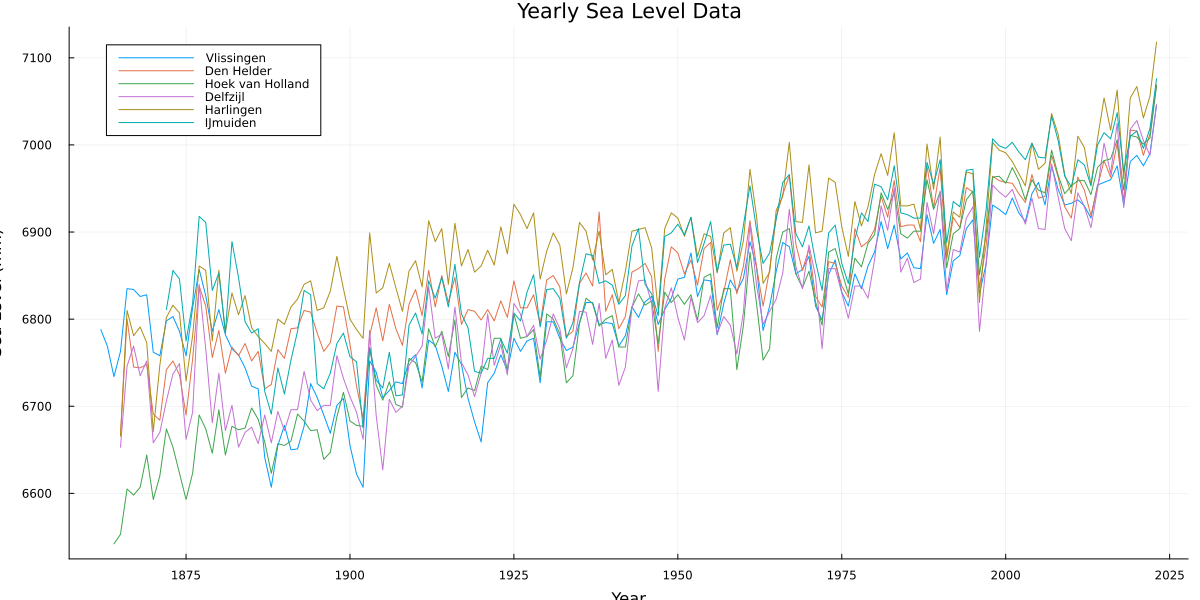

In [31]:
# Plot the yearly data
vlissingen_yearly = psmsl_yearly["vlissingen"]
using Plots
plot(vlissingen_yearly.Year, vlissingen_yearly.SeaLevel, label=labels["vlissingen"], xlabel="Year", ylabel="Sea Level (mm)", 
title="Yearly Sea Level Data", legend=:topleft,size=(1200,600))
for (key, value) in psmsl_yearly
    if key!="vlissingen"
        plot!(value.Year, value.SeaLevel, label=labels[key])
    end
end
plot!()

In [64]:
function download_matroos(location::String,source::String,unit::String,
    tstart::String,tstop::String)
    # the noos server is available to the public, but has a limited dataset
    url="https://noos.matroos.rws.nl/direct/get_series.php?loc=$(location)&source=$(source)&unit=$(unit)&tstart=$(tstart)&tstop=$(tstop)"
    response = HTTP.get(url)
    # Read the CSV data into a DataFrame
    df = CSV.File(HTTP.get(url).body, delim=' ', ignorerepeated=true, skipto=12, header=false) |> DataFrame
    rename!(df,["timestring","Sealevel"])
    df.Time = DateTime.(string.(df.timestring), "yyyymmddHHMM")
    return df
end

download_matroos (generic function with 1 method)

In [ ]:
# define mean
function mean(values)
    return sum(values)/length(values)
end

In [ ]:
# Download matroos data
matroos_years = [2022,2023,2024]
matroos_locations = keys(labels)
matroos_source = "observed"
matroos_unit = "waterlevel"
matroos_tide_unit = "waterlevel_astro"
start_of_year(year)="$(year)01010000"
end_of_year(year)="$(year)12312350"
matroos_10minute_data = Dict{String,DataFrame}()
for year in matroos_years
    for location in matroos_locations
        println("Downloading data for $(location) in $(year)")
        matroos_10minute_data["$(location)_$(year)"] = download_matroos(location,matroos_source,matroos_unit,start_of_year(year),end_of_year(year))
    end
end
# matroos_10minute_tide_data = Dict{String,DataFrame}()
# for year in matroos_years
#     for location in matroos_locations
#         println("Downloading tide data for $(location) in $(year)")
#         matroos_10minute_tide_data["$(location)_$(year)"] = download_matroos(location,matroos_source,matroos_tide_unit,start_of_year(year),end_of_year(year))
#     end
# end



In [ ]:
#Compute yearly averages from 10minute data
matroos_yearly = Dict{String,DataFrame}()
const m_to_mm=1000.0
for location in matroos_locations
    values=zeros(length(matroos_years))
    for (i,year) in enumerate(matroos_years)
        mean_value=mean(matroos_10minute_data["$(location)_$(year)"].Sealevel)
        values[i]=m_to_mm*mean_value
    end
    matroos_yearly[location]=DataFrame(Year=matroos_years,SeaLevel=values)
end

@show matroos_yearly["denhelder"]

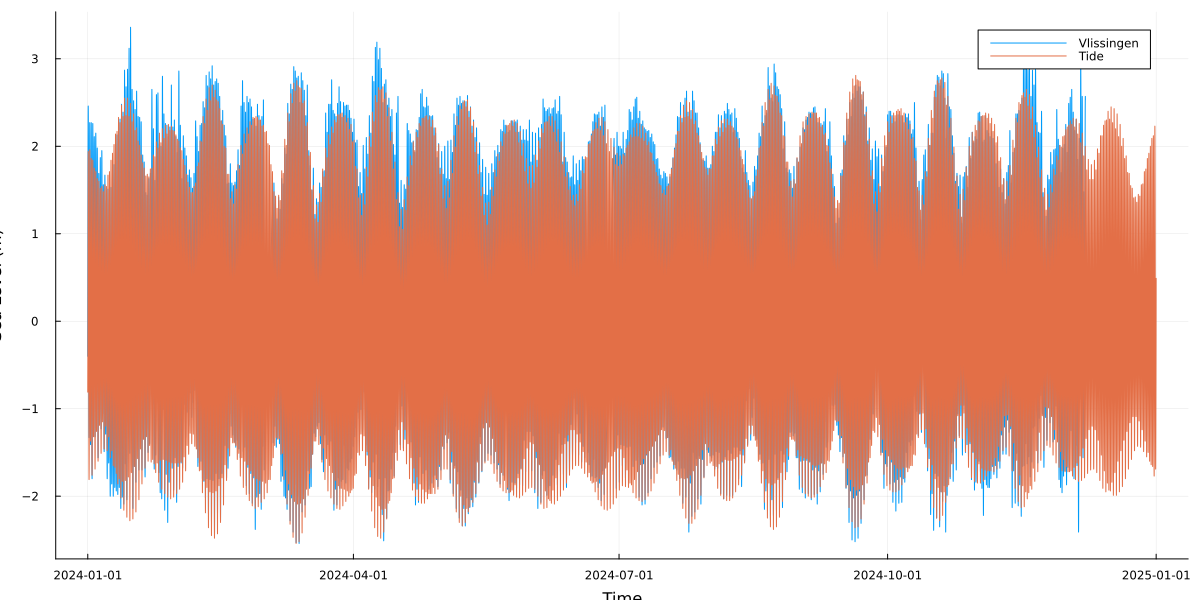

In [71]:
this=matroos_10minute_data["vlissingen_2024"]
tide=matroos_10minute_tide_data["vlissingen_2024"]

@show this
plot(this.Time, this.Sealevel, label=labels["vlissingen"], xlabel="Time", ylabel="Sea Level (m)",size=(1200,600))
plot!(tide.Time, tide.Sealevel, label="Tide")

In [72]:
@show length(tide.Sealevel), 24*6*365

(52704, 52560)